In [13]:
import Environment
import Shop
from mab.ucb_learner import *
from utilities import *

In [14]:
#### TODO büyük learner ekle

shop_ts = Shop.Shop()
shop_big_ts = Shop.Shop()

env = Environment.Environment(shop_ts.prices1, shop_ts.prices2, shop_ts.discounts)

shop_ts.set_conv_rate(env.true_conv1, env.true_conv2)
shop_big_ts.set_conv_rate(env.true_conv1, env.true_conv2)


price_arms = [(i, j) for i in range(len(shop_ts.prices1)) for j in range(len(shop_ts.prices2))]
n_price_arms = len(price_arms)

matching_arms = [(i, j, k, l) for i in range(len(shop_ts.prices1)) for j in range(len(shop_ts.prices2)) for k in range(shop_ts.n_classes) for l in range(len(shop_ts.discounts))]
n_matching_arms = len(matching_arms)



shop_ts.set_price_learner('TS', n_price_arms)
shop_ts.set_assignment_learner('TS', n_matching_arms)

shop_big_ts.set_assignment_learner('TS', n_matching_arms)

In [15]:
generated_promo_ratios = np.array([0.4, 0.25, 0.2, 0.15])
max_ind_reward = max(env.prices1) + max(env.prices2)

In [16]:
print(max_ind_reward)

540.0


In [17]:
days = 365

ts_rewards_per_class_per_day = []
big_ts_rewards_per_class_per_day = []

customers_em = np.array([0, 0, 0, 0])
customers_ie = np.array([25, 25, 25, 25])

for day in range(days):
    if day == 0:
        #shop_ucb.set_expected_customers(customers_ie)
        shop_ts.set_expected_customers(customers_ie)
        shop_big_ts.set_expected_customers(customers_ie)
    else:
        customers_em = (customers_em*(day-1) + env.customers) / day
        #shop_ucb.set_expected_customers((customers_em + 0.99).astype(int))
        shop_ts.set_expected_customers((customers_em + 0.99).astype(int))
        shop_big_ts.set_expected_customers((customers_em + 0.99).astype(int))
    
    # select the price for 2 step learner
    chosen_price_tuple_idx_ts = shop_ts.price_learner.pull_arm()

    price1idx_ts = price_arms[chosen_price_tuple_idx_ts][0]
    price2idx_ts = price_arms[chosen_price_tuple_idx_ts][1]
    price1_ts = env.prices1[price_arms[chosen_price_tuple_idx_ts][0]]
    price2_ts = env.prices2[price_arms[chosen_price_tuple_idx_ts][1]]

    # perform matching and get promo fractions for 2 step learner
    expected_customers_ts = shop_ts.get_customer_list()
    expected_promos_ts = shop_ts.get_promo_list(generated_promo_ratios)
    matched_tuples_ts = shop_ts.assignment_learner.pull_arm_matching(expected_customers_ts, expected_promos_ts, matching_arms, price1idx_ts, price2idx_ts)
    promo_fractions_ts = shop_ts.get_promo_fractions_from_tuples(matched_tuples_ts)

    # get promo fractions and prices for big learner
    expected_customers_big_ts = shop_big_ts.get_customer_list()
    expected_promos_big_ts = shop_big_ts.get_promo_list(generated_promo_ratios)
    matched_tuples_big_ts, matching_arm_index_big_ts = shop_big_ts.assignment_learner.pull_arm_all(expected_customers_big_ts, expected_promos_big_ts, matching_arms, len(env.prices1), len(env.prices2))
    promo_fractions_big_ts = shop_big_ts.get_promo_fractions_from_tuples(matched_tuples_big_ts)

    price1idx_big_ts = matching_arms[matching_arm_index_big_ts][0]
    price2idx_big_ts = matching_arms[matching_arm_index_big_ts][1]
    price1_big_ts = env.prices1[price1idx_big_ts]
    price2_big_ts = env.prices2[price2idx_big_ts]

    # simulate the day
    env.generate_next_day_customers()

    enum_customers = list(enumerate(env.customers))
    customers = np.concatenate([np.ones(c).astype(int)*p for p,c in enum_customers])
    np.random.shuffle(customers)

    revenue_ts = []
    revenue_big_ts = []

    big_ts_total_reward = 0
    ts_total_reward = 0

    c_count = 0

    for cust in customers:
        ts_ind_reward = 0

        selected_promo_ts = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions_ts[cust])
        selected_promo_big_ts = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions_big_ts[cust])

        ts_buy1 = env.round1(cust, price1_ts)
        ts_buy2 = 0
        if ts_buy1:
            ts_buy2 = env.round2(cust, selected_promo_ts, price2_ts)

        big_ts_buy1 = env.round1(cust, price1_big_ts)
        big_ts_buy2 = 0
        if big_ts_buy1:
            big_ts_buy2 = env.round2(cust, selected_promo_big_ts, price2_big_ts)
        
        ts_ind_reward = ts_buy1*price1_ts + ts_buy2*price2_ts*(1-shop_ts.discounts[selected_promo_ts])
        big_ts_ind_reward = big_ts_buy1*price1_big_ts + big_ts_buy2*price2_big_ts*(1-shop_big_ts.discounts[selected_promo_big_ts])
        
        norm_ts_ind_reward = ts_ind_reward / max_ind_reward
        norm_big_ts_ind_reward = big_ts_ind_reward / max_ind_reward

        # update price learner and assignment learner
        shop_ts.price_learner.update(chosen_price_tuple_idx_ts, norm_ts_ind_reward)

        matching_arm_index_ts = matching_arms.index((price1idx_ts, price2idx_ts, cust, selected_promo_ts))
        shop_ts.assignment_learner.update(matching_arm_index_ts, norm_ts_ind_reward)

        shop_big_ts.assignment_learner.update(matching_arm_index_big_ts, norm_big_ts_ind_reward)

        revenue_ts.append(ts_ind_reward)
        revenue_big_ts.append(big_ts_ind_reward)

    ts_rewards_per_class_per_day.append(np.mean(revenue_ts))
    big_ts_rewards_per_class_per_day.append(np.mean(revenue_big_ts))









Text(0, 0.5, 'Revenue')

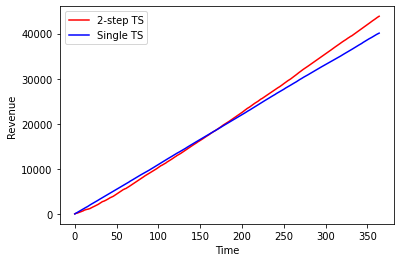

In [18]:
import matplotlib.pyplot as plt
#plt.plot(np.cumsum(c_rewards_per_class_per_day), color='green', label='Clairvoyant')
plt.plot(np.cumsum(ts_rewards_per_class_per_day), color='red', label='2-step TS')
plt.plot(np.cumsum(big_ts_rewards_per_class_per_day), color='blue', label='Single TS')
#plt.plot(np.cumsum(c_expected_per_day), color='black', label='Expected')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Revenue')

In [14]:
matching_arms

[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 0, 2),
 (0, 0, 0, 3),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 0, 1, 2),
 (0, 0, 1, 3),
 (0, 0, 2, 0),
 (0, 0, 2, 1),
 (0, 0, 2, 2),
 (0, 0, 2, 3),
 (0, 0, 3, 0),
 (0, 0, 3, 1),
 (0, 0, 3, 2),
 (0, 0, 3, 3),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 0, 2),
 (0, 1, 0, 3),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (0, 1, 1, 2),
 (0, 1, 1, 3),
 (0, 1, 2, 0),
 (0, 1, 2, 1),
 (0, 1, 2, 2),
 (0, 1, 2, 3),
 (0, 1, 3, 0),
 (0, 1, 3, 1),
 (0, 1, 3, 2),
 (0, 1, 3, 3),
 (0, 2, 0, 0),
 (0, 2, 0, 1),
 (0, 2, 0, 2),
 (0, 2, 0, 3),
 (0, 2, 1, 0),
 (0, 2, 1, 1),
 (0, 2, 1, 2),
 (0, 2, 1, 3),
 (0, 2, 2, 0),
 (0, 2, 2, 1),
 (0, 2, 2, 2),
 (0, 2, 2, 3),
 (0, 2, 3, 0),
 (0, 2, 3, 1),
 (0, 2, 3, 2),
 (0, 2, 3, 3),
 (0, 3, 0, 0),
 (0, 3, 0, 1),
 (0, 3, 0, 2),
 (0, 3, 0, 3),
 (0, 3, 1, 0),
 (0, 3, 1, 1),
 (0, 3, 1, 2),
 (0, 3, 1, 3),
 (0, 3, 2, 0),
 (0, 3, 2, 1),
 (0, 3, 2, 2),
 (0, 3, 2, 3),
 (0, 3, 3, 0),
 (0, 3, 3, 1),
 (0, 3, 3, 2),
 (0, 3, 3, 3),
 (0, 4, 0, 0),
 (0, 4, 0, 1),
 (0, 4, 0,

In [7]:
cost = np.array([[4, 1, 3], [2, 0, 5], [3, 2, 2]])
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(-cost)
cost[row_ind, col_ind].sum()

11